# Classifier using LSTM layers

## 1. Importing Libraries

In [18]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [19]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [20]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

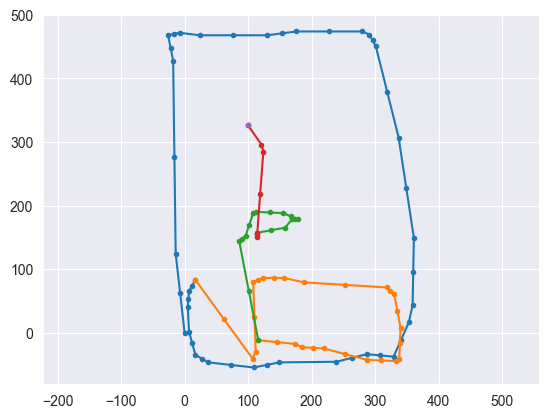

In [21]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [22]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    camera_labels = np.ones(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2
    calculator_labels = np.zeros(calculator_drawings.shape[0])

    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [24]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

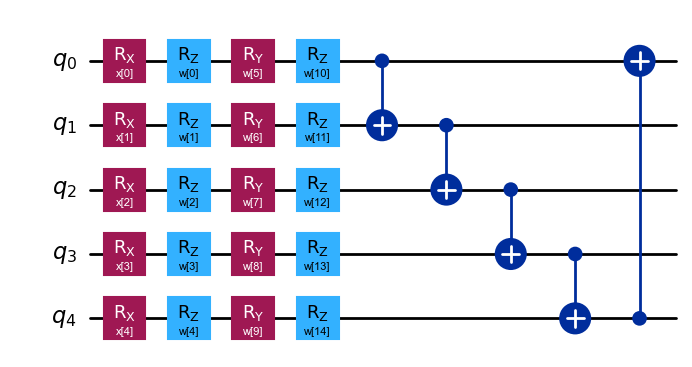

In [26]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    for i in range(n):
        circuit.rz(weights[i], i)

    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool3(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [28]:
checkpoint_filepath = 'models/quantum_lstm/best_model_weights_3classes.pth'

In [29]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 192/192 [11:13<00:00,  3.51s/it]


Epoch 1, Accuracy: 0.489013671875, Loss: 1.0690230966235201, Validation Accuracy: 0.5042317708333334, Validation Loss: 1.015908122062683


100%|██████████| 192/192 [11:59<00:00,  3.75s/it]


Epoch 2, Accuracy: 0.5364583333333334, Loss: 0.9977884261558453, Validation Accuracy: 0.6031901041666666, Validation Loss: 0.9289066791534424


100%|██████████| 192/192 [11:47<00:00,  3.69s/it]


Epoch 3, Accuracy: 0.592529296875, Loss: 0.9031369406729937, Validation Accuracy: 0.6168619791666666, Validation Loss: 0.8600630164146423


100%|██████████| 192/192 [14:13<00:00,  4.44s/it]


Epoch 4, Accuracy: 0.726806640625, Loss: 0.8099998543038964, Validation Accuracy: 0.82421875, Validation Loss: 0.73625248670578


100%|██████████| 192/192 [15:07<00:00,  4.73s/it]


Epoch 5, Accuracy: 0.8339029947916666, Loss: 0.6630814468177656, Validation Accuracy: 0.8684895833333334, Validation Loss: 0.5815206170082092


100%|██████████| 192/192 [11:16<00:00,  3.53s/it]


Epoch 6, Accuracy: 0.8794759114583334, Loss: 0.5356647594211003, Validation Accuracy: 0.8831380208333334, Validation Loss: 0.501209557056427


100%|██████████| 192/192 [11:36<00:00,  3.63s/it]


Epoch 7, Accuracy: 0.9054361979166666, Loss: 0.4401142029091716, Validation Accuracy: 0.9013671875, Validation Loss: 0.42008063197135925


100%|██████████| 192/192 [11:08<00:00,  3.48s/it]


Epoch 8, Accuracy: 0.9134114583333334, Loss: 0.38693475428347784, Validation Accuracy: 0.9153645833333334, Validation Loss: 0.36784371733665466


100%|██████████| 192/192 [10:56<00:00,  3.42s/it]


Epoch 9, Accuracy: 0.9247233072916666, Loss: 0.3413274180299292, Validation Accuracy: 0.9215494791666666, Validation Loss: 0.33007293939590454


100%|██████████| 192/192 [10:53<00:00,  3.41s/it]


Epoch 10, Accuracy: 0.9254557291666666, Loss: 0.3163843715252976, Validation Accuracy: 0.9313151041666666, Validation Loss: 0.2923985719680786


100%|██████████| 192/192 [10:50<00:00,  3.39s/it]


Epoch 11, Accuracy: 0.9358723958333334, Loss: 0.27468763501383364, Validation Accuracy: 0.9342447916666666, Validation Loss: 0.2699265778064728


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 12, Accuracy: 0.94091796875, Loss: 0.25213505459638935, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.25209009647369385


100%|██████████| 192/192 [10:47<00:00,  3.37s/it]


Epoch 13, Accuracy: 0.9435221354166666, Loss: 0.23566484629797438, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.2392038255929947


100%|██████████| 192/192 [10:49<00:00,  3.38s/it]


Epoch 14, Accuracy: 0.94970703125, Loss: 0.21069373365025967, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.23271197080612183


100%|██████████| 192/192 [10:53<00:00,  3.40s/it]


Epoch 15, Accuracy: 0.9498697916666666, Loss: 0.20166593231260777, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.22225375473499298


100%|██████████| 192/192 [10:51<00:00,  3.39s/it]


Epoch 16, Accuracy: 0.9561360677083334, Loss: 0.18024790527609488, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.21419744193553925


100%|██████████| 192/192 [10:49<00:00,  3.38s/it]


Epoch 17, Accuracy: 0.9585774739583334, Loss: 0.17024883104022592, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.21377742290496826


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 18, Accuracy: 0.959228515625, Loss: 0.1583564285732185, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.21533764898777008


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 19, Accuracy: 0.963134765625, Loss: 0.14601042857005572, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.21177643537521362


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 20, Accuracy: 0.9667154947916666, Loss: 0.13496970647247508, Validation Accuracy: 0.9365234375, Validation Loss: 0.2234971672296524


100%|██████████| 192/192 [10:53<00:00,  3.40s/it]


Epoch 21, Accuracy: 0.9705403645833334, Loss: 0.12559934550275406, Validation Accuracy: 0.9397786458333334, Validation Loss: 0.2019672989845276


100%|██████████| 192/192 [10:54<00:00,  3.41s/it]


Epoch 22, Accuracy: 0.9720865885416666, Loss: 0.11565194164480393, Validation Accuracy: 0.9378255208333334, Validation Loss: 0.20666170120239258


100%|██████████| 192/192 [10:53<00:00,  3.40s/it]


Epoch 23, Accuracy: 0.9708658854166666, Loss: 0.1112628352517883, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2023358792066574


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 24, Accuracy: 0.974365234375, Loss: 0.10490779861963044, Validation Accuracy: 0.9348958333333334, Validation Loss: 0.21637402474880219


100%|██████████| 192/192 [10:54<00:00,  3.41s/it]


Epoch 25, Accuracy: 0.9769694010416666, Loss: 0.09518437919905409, Validation Accuracy: 0.9290364583333334, Validation Loss: 0.22754675149917603


100%|██████████| 192/192 [10:56<00:00,  3.42s/it]


Epoch 26, Accuracy: 0.9751790364583334, Loss: 0.09732264187186956, Validation Accuracy: 0.935546875, Validation Loss: 0.20050258934497833


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 27, Accuracy: 0.978515625, Loss: 0.0833945289098968, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.2025991827249527


100%|██████████| 192/192 [10:46<00:00,  3.37s/it]


Epoch 28, Accuracy: 0.984375, Loss: 0.06729586892955315, Validation Accuracy: 0.9300130208333334, Validation Loss: 0.23917828500270844


100%|██████████| 192/192 [10:30<00:00,  3.28s/it]


Epoch 29, Accuracy: 0.98583984375, Loss: 0.06335294640545423, Validation Accuracy: 0.9264322916666666, Validation Loss: 0.2579737603664398


100%|██████████| 192/192 [12:51<00:00,  4.02s/it]


Epoch 30, Accuracy: 0.9832356770833334, Loss: 0.06724884956687067, Validation Accuracy: 0.9365234375, Validation Loss: 0.21736609935760498


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 31, Accuracy: 0.987548828125, Loss: 0.058179359223383166, Validation Accuracy: 0.935546875, Validation Loss: 0.23632223904132843


100%|██████████| 192/192 [09:53<00:00,  3.09s/it]


Epoch 32, Accuracy: 0.9816080729166666, Loss: 0.07297098497413874, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.231211856007576


100%|██████████| 192/192 [09:53<00:00,  3.09s/it]


Epoch 33, Accuracy: 0.9833170572916666, Loss: 0.06922519865717429, Validation Accuracy: 0.9300130208333334, Validation Loss: 0.2274722456932068


100%|██████████| 192/192 [09:52<00:00,  3.08s/it]


Epoch 34, Accuracy: 0.9888509114583334, Loss: 0.051161309660528786, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.24636994302272797


100%|██████████| 192/192 [09:51<00:00,  3.08s/it]


Epoch 35, Accuracy: 0.9893391927083334, Loss: 0.04867718641859634, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.2217109203338623


100%|██████████| 192/192 [09:52<00:00,  3.09s/it]


Epoch 36, Accuracy: 0.98828125, Loss: 0.05035801622337507, Validation Accuracy: 0.93359375, Validation Loss: 0.22701531648635864


100%|██████████| 192/192 [09:53<00:00,  3.09s/it]


Epoch 37, Accuracy: 0.9881998697916666, Loss: 0.04935380714596249, Validation Accuracy: 0.9290364583333334, Validation Loss: 0.2653391659259796


100%|██████████| 192/192 [09:50<00:00,  3.08s/it]


Epoch 38, Accuracy: 0.989990234375, Loss: 0.04542864487545254, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.2607331871986389


100%|██████████| 192/192 [09:49<00:00,  3.07s/it]


Epoch 39, Accuracy: 0.9908854166666666, Loss: 0.0381652593932813, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.26015421748161316


100%|██████████| 192/192 [10:22<00:00,  3.24s/it]


Epoch 40, Accuracy: 0.9913736979166666, Loss: 0.04073458269219069, Validation Accuracy: 0.9407552083333334, Validation Loss: 0.24217897653579712


100%|██████████| 192/192 [10:29<00:00,  3.28s/it]


Epoch 41, Accuracy: 0.9935709635416666, Loss: 0.031903309616609477, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.26657524704933167


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 42, Accuracy: 0.9890950520833334, Loss: 0.04601454239067001, Validation Accuracy: 0.9319661458333334, Validation Loss: 0.24850411713123322


100%|██████████| 192/192 [10:12<00:00,  3.19s/it]


Epoch 43, Accuracy: 0.9903157552083334, Loss: 0.04322270148744186, Validation Accuracy: 0.9384765625, Validation Loss: 0.24419011175632477


100%|██████████| 192/192 [10:18<00:00,  3.22s/it]


Epoch 44, Accuracy: 0.9922688802083334, Loss: 0.03632807321021877, Validation Accuracy: 0.919921875, Validation Loss: 0.27859631180763245


100%|██████████| 192/192 [10:08<00:00,  3.17s/it]


Epoch 45, Accuracy: 0.9881998697916666, Loss: 0.0444621656400462, Validation Accuracy: 0.9384765625, Validation Loss: 0.248701274394989


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 46, Accuracy: 0.9930826822916666, Loss: 0.03173901198654979, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.26607003808021545


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 47, Accuracy: 0.9923502604166666, Loss: 0.03280901867401553, Validation Accuracy: 0.9322916666666666, Validation Loss: 0.27023234963417053


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 48, Accuracy: 0.9896647135416666, Loss: 0.03904512785811676, Validation Accuracy: 0.9348958333333334, Validation Loss: 0.24588006734848022


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 49, Accuracy: 0.9903971354166666, Loss: 0.03828074594882006, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.25615212321281433


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 50, Accuracy: 0.9930826822916666, Loss: 0.031103938847081736, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.26487770676612854


100%|██████████| 192/192 [09:56<00:00,  3.10s/it]


Epoch 51, Accuracy: 0.99560546875, Loss: 0.025348281141001888, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.2867791950702667


100%|██████████| 192/192 [09:55<00:00,  3.10s/it]


Epoch 52, Accuracy: 0.9903971354166666, Loss: 0.03723927031872639, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.23273056745529175


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 53, Accuracy: 0.9920247395833334, Loss: 0.03293056314335748, Validation Accuracy: 0.93359375, Validation Loss: 0.26518702507019043


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 54, Accuracy: 0.9954427083333334, Loss: 0.023642696476599667, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.29240378737449646


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 55, Accuracy: 0.989990234375, Loss: 0.04094248559219219, Validation Accuracy: 0.9348958333333334, Validation Loss: 0.2698262333869934


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 56, Accuracy: 0.99267578125, Loss: 0.03140353557682829, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.26473268866539


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 57, Accuracy: 0.9947916666666666, Loss: 0.02680521726263881, Validation Accuracy: 0.9326171875, Validation Loss: 0.26731422543525696


100%|██████████| 192/192 [10:00<00:00,  3.13s/it]


Epoch 58, Accuracy: 0.9938151041666666, Loss: 0.02759238462143306, Validation Accuracy: 0.9192708333333334, Validation Loss: 0.34551429748535156


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 59, Accuracy: 0.9910481770833334, Loss: 0.03695321609120583, Validation Accuracy: 0.9391276041666666, Validation Loss: 0.2607930302619934


100%|██████████| 192/192 [10:15<00:00,  3.20s/it]


Epoch 60, Accuracy: 0.9956868489583334, Loss: 0.022582259651244385, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2720552682876587


100%|██████████| 192/192 [10:01<00:00,  3.14s/it]


Epoch 61, Accuracy: 0.9930013020833334, Loss: 0.02898110749447369, Validation Accuracy: 0.9339192708333334, Validation Loss: 0.274899959564209


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 62, Accuracy: 0.9954427083333334, Loss: 0.02038224171701586, Validation Accuracy: 0.9313151041666666, Validation Loss: 0.2947137653827667


100%|██████████| 192/192 [09:56<00:00,  3.11s/it]


Epoch 63, Accuracy: 0.9935709635416666, Loss: 0.02765772274506162, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.27964726090431213


100%|██████████| 192/192 [09:56<00:00,  3.10s/it]


Epoch 64, Accuracy: 0.9945475260416666, Loss: 0.02360829373234689, Validation Accuracy: 0.92578125, Validation Loss: 0.3124537169933319


100%|██████████| 192/192 [10:13<00:00,  3.19s/it]


Epoch 65, Accuracy: 0.9943033854166666, Loss: 0.023871922027562203, Validation Accuracy: 0.93359375, Validation Loss: 0.2793903350830078


100%|██████████| 192/192 [10:23<00:00,  3.25s/it]


Epoch 66, Accuracy: 0.993408203125, Loss: 0.026355352045356994, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2666705250740051


100%|██████████| 192/192 [10:21<00:00,  3.24s/it]


Epoch 67, Accuracy: 0.9930013020833334, Loss: 0.027063522007665597, Validation Accuracy: 0.9267578125, Validation Loss: 0.32968053221702576


100%|██████████| 192/192 [10:22<00:00,  3.24s/it]


Epoch 68, Accuracy: 0.9921875, Loss: 0.029529225552929955, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2876153886318207


100%|██████████| 192/192 [10:34<00:00,  3.31s/it]


Epoch 69, Accuracy: 0.9931640625, Loss: 0.029225484755443176, Validation Accuracy: 0.9326171875, Validation Loss: 0.27853360772132874


100%|██████████| 192/192 [10:38<00:00,  3.32s/it]


Epoch 70, Accuracy: 0.9961751302083334, Loss: 0.01895722674695814, Validation Accuracy: 0.93359375, Validation Loss: 0.294925719499588


100%|██████████| 192/192 [10:46<00:00,  3.37s/it]


Epoch 71, Accuracy: 0.996337890625, Loss: 0.018179020868653122, Validation Accuracy: 0.9401041666666666, Validation Loss: 0.28317132592201233


100%|██████████| 192/192 [10:23<00:00,  3.25s/it]


Epoch 72, Accuracy: 0.9969075520833334, Loss: 0.015642289185052505, Validation Accuracy: 0.9407552083333334, Validation Loss: 0.27512606978416443


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 73, Accuracy: 0.9939778645833334, Loss: 0.023641534508594002, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.2964385449886322


100%|██████████| 192/192 [10:13<00:00,  3.19s/it]


Epoch 74, Accuracy: 0.994873046875, Loss: 0.02038254380507472, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.3322399854660034


100%|██████████| 192/192 [10:18<00:00,  3.22s/it]


Epoch 75, Accuracy: 0.9916178385416666, Loss: 0.0332908780243694, Validation Accuracy: 0.921875, Validation Loss: 0.29225844144821167


100%|██████████| 192/192 [10:51<00:00,  3.39s/it]


Epoch 76, Accuracy: 0.9927571614583334, Loss: 0.026859185615952203, Validation Accuracy: 0.9345703125, Validation Loss: 0.2904128134250641


100%|██████████| 192/192 [10:25<00:00,  3.26s/it]


Epoch 77, Accuracy: 0.9964192708333334, Loss: 0.017007690029762063, Validation Accuracy: 0.9345703125, Validation Loss: 0.2766477167606354


100%|██████████| 192/192 [10:30<00:00,  3.29s/it]


Epoch 78, Accuracy: 0.9938151041666666, Loss: 0.02342017136591797, Validation Accuracy: 0.935546875, Validation Loss: 0.29189518094062805


100%|██████████| 192/192 [10:37<00:00,  3.32s/it]


Epoch 79, Accuracy: 0.997802734375, Loss: 0.01276741815066392, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.27835813164711


100%|██████████| 192/192 [10:41<00:00,  3.34s/it]


Epoch 80, Accuracy: 0.9962565104166666, Loss: 0.018047226849982206, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.29936954379081726


100%|██████████| 192/192 [10:14<00:00,  3.20s/it]


Epoch 81, Accuracy: 0.994140625, Loss: 0.0215163735532163, Validation Accuracy: 0.9339192708333334, Validation Loss: 0.2846418023109436


100%|██████████| 192/192 [10:31<00:00,  3.29s/it]


Epoch 82, Accuracy: 0.996826171875, Loss: 0.014599020845101526, Validation Accuracy: 0.9397786458333334, Validation Loss: 0.29929298162460327


100%|██████████| 192/192 [10:15<00:00,  3.21s/it]


Epoch 83, Accuracy: 0.9961751302083334, Loss: 0.015618185013105782, Validation Accuracy: 0.9348958333333334, Validation Loss: 0.3128628134727478


100%|██████████| 192/192 [10:47<00:00,  3.37s/it]


Epoch 84, Accuracy: 0.9933268229166666, Loss: 0.027302548005536664, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.2787732183933258


100%|██████████| 192/192 [10:37<00:00,  3.32s/it]


Epoch 85, Accuracy: 0.996826171875, Loss: 0.015085603915091875, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.28206127882003784


100%|██████████| 192/192 [10:27<00:00,  3.27s/it]


Epoch 86, Accuracy: 0.9964192708333334, Loss: 0.016286556362198706, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.283964604139328


100%|██████████| 192/192 [10:42<00:00,  3.34s/it]


Epoch 87, Accuracy: 0.99267578125, Loss: 0.026641001665363245, Validation Accuracy: 0.931640625, Validation Loss: 0.31407973170280457


100%|██████████| 192/192 [10:09<00:00,  3.18s/it]


Epoch 88, Accuracy: 0.990966796875, Loss: 0.030364947710040724, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.271316796541214


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 89, Accuracy: 0.998291015625, Loss: 0.011044572823569373, Validation Accuracy: 0.9391276041666666, Validation Loss: 0.2777097225189209


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 90, Accuracy: 0.9971516927083334, Loss: 0.013940848206402734, Validation Accuracy: 0.9274088541666666, Validation Loss: 0.3126204013824463


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 91, Accuracy: 0.9952799479166666, Loss: 0.01976914508304617, Validation Accuracy: 0.9375, Validation Loss: 0.2847541868686676


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 92, Accuracy: 0.9969075520833334, Loss: 0.014759700071105422, Validation Accuracy: 0.939453125, Validation Loss: 0.2811732590198517


100%|██████████| 192/192 [09:58<00:00,  3.12s/it]


Epoch 93, Accuracy: 0.9959309895833334, Loss: 0.016227038903404416, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.3195565640926361


100%|██████████| 192/192 [09:57<00:00,  3.11s/it]


Epoch 94, Accuracy: 0.997314453125, Loss: 0.01253432578232605, Validation Accuracy: 0.9397786458333334, Validation Loss: 0.30480456352233887


100%|██████████| 192/192 [09:56<00:00,  3.10s/it]


Epoch 95, Accuracy: 0.996826171875, Loss: 0.013876227063519764, Validation Accuracy: 0.9375, Validation Loss: 0.2879730761051178


100%|██████████| 192/192 [09:54<00:00,  3.10s/it]


Epoch 96, Accuracy: 0.9970703125, Loss: 0.012498437905984853, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.30683597922325134


100%|██████████| 192/192 [09:53<00:00,  3.09s/it]


Epoch 97, Accuracy: 0.9981282552083334, Loss: 0.009480567769060144, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.3041152060031891


100%|██████████| 192/192 [09:52<00:00,  3.08s/it]


Epoch 98, Accuracy: 0.9960123697916666, Loss: 0.016605337220122845, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.3289453089237213


100%|██████████| 192/192 [09:53<00:00,  3.09s/it]


Epoch 99, Accuracy: 0.9971516927083334, Loss: 0.014012328812289828, Validation Accuracy: 0.9326171875, Validation Loss: 0.3110136389732361


100%|██████████| 192/192 [09:52<00:00,  3.09s/it]


Epoch 100, Accuracy: 0.998291015625, Loss: 0.009530480176787629, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.31643709540367126


## 5. Model Evaluation

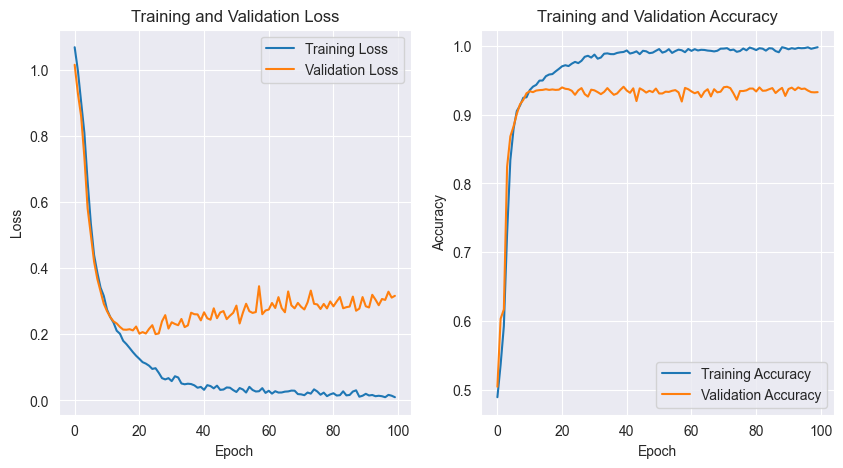

In [30]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [35]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [37]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: cell phone
True class: cell phone
